In [1096]:
%matplotlib inline
import seaborn as sns
import numpy as np
import pandas as pd
import pylab
import matplotlib.pyplot as plt
from os import system
from scipy.cluster.hierarchy import fcluster,linkage,cophenet

global familymatching_thresh
global enough_PE2barcode_numthresh 
global pe2readthresh 
global cellname_col 
global totalread_col 
global pe2read_col 
global barcodelist_col 
global barcodecnt_col 
global barcodenum_col 


familymatching_thresh = 0
enough_PE2barcode_numthresh = 5
pe2readthresh = 1
cellname_col = 0
totalread_col = 1
pe2read_col = 2
barcodelist_col = 3
barcodecnt_col = 4
barcodenum_col = 5

def indexing(seq,key,equal):
    ### Find the element in the list that matches a key
    if equal:
        return set([i for i in xrange(len(seq)) if seq[i]==key])
    else:
        return set([i for i in xrange(len(seq)) if seq[i]!=key])

def dist(seq1,seq2):
    ### Calculate the  Levenshtein distance distance of two string, considering 'N' as wildcard
    n1 = indexing(seq1,'N',False)
    n2 = indexing(seq2,'N',False)
    nindex = list(set.intersection(n1,n2))
    return sum([1 for x in nindex if seq1[x]!=seq2[x]])

def listdist(seqs1,seqs2,dist_thresh):
    ### If any element of seqs1 matches any element of seq2, we call it a match
    for idx1 in range(len(seqs1)):
        for idx2 in range(len(seqs2)):
            t_dist = dist(seqs1[idx1],seqs2[idx2])
            if t_dist <= dist_thresh:
                return 0
    return 1

def distplot(data,xaxis):
    plt.figure()
    x = pd.Series(data, name=xaxis)
    ax = sns.distplot(x);
    pylab.show() 
    
def regplot(data,xlab,ylab):
    plt.figure()
    d = pd.DataFrame(data,columns=[xlab,ylab])
    ax = sns.regplot(x=xlab,y=ylab,data=d)
    pylab.show()

In [1097]:
def family(withbarcode):
    num = len(withbarcode)
    alldist = np.zeros([num,num])
    for idx1 in range(num):
        for idx2 in range(num):
            alldist[idx1,idx2] = 0 if idx1 == idx2 \
            else listdist(withbarcode[idx1][barcodelist_col].split(','),withbarcode[idx2][barcodelist_col].split(','),familymatching_thresh)
    
    cond_dist = []
    for idx1 in range(num-1):
        for idx2 in range(idx1+1,num):
            cond_dist.append(alldist[idx1,idx2])
    
    link = linkage(cond_dist,method='single')
    cell2lineage = fcluster(link,0.5,criterion='distance')
    cell2lineage = [x-1 for x in cell2lineage]
    
    lineages = np.unique(cell2lineage)
    lineage2cell = [None]*len(lineages)
    for lineage in lineages: 
        lineage2cell[lineage] = [cell for cell in range(len(cell2lineage)) if cell2lineage[cell]==lineage]
    
    print '(Recap)Num of valid cell :',len(withbarcode)
    print 'Total num of barcode combo (family):',len(lineages)             
    print 'Num of invalid family with only one cell:', len([cells for cells in lineage2cell if len(cells)==1]) 
    
    validfamily = [lineage for lineage in lineages if len(lineage2cell[lineage])>1]
    validfamily_cellcnt = [len(lineage2cell[x]) for x in validfamily]
    print 'Num of valid family (with more than 1 cell):',len(validfamily)
    print 'Num of valid cells covered by valid family (with more than one cells):',sum(validfamily_cellcnt)
    print 'Median num of valid cells in a valid family:',np.median(validfamily_cellcnt)
    
    distplot([len(cells) for cells in lineage2cell],"Num of cell in each family")
    distplot([x for x in validfamily_cellcnt],"Num of cell in each VALID family")
    
    print '\nThe barcode-combo of all the cells in the biggest family:'
    largestfamily = lineage2cell[lineages[np.argmax(validfamily_cellcnt)]]
    largestfamily_barcode = [withbarcode[x][barcodelist_col] for x in largestfamily]
    print '(size:',len(largestfamily_barcode),')'
    print largestfamily_barcode
    
    target = []
    for x in largestfamily_barcode:
        target = target + x.split(',')
    target = list(set(target))
    
    cond_dist = []
    for i in range(len(target)-1):
        for j in range(i+1,len(target)):
            cond_dist.append(dist(target[i],target[j]))
    
    link = linkage(cond_dist,method='single')
    target2clst = fcluster(link,0.5,criterion='distance')
    print 'num of unique barcodes in this family (tolerance<=0bp):',len(np.unique(target2clst))
    
    target2clst = [x-1 for x in target2clst]

    clst2cell = {}
    for x in largestfamily_barcode:
        t_target = x.split(',')
        for y in t_target:
            if target2clst[target.index(y)] not in clst2cell.keys():
                clst2cell[target2clst[target.index(y)]] = [x]
            else:
                clst2cell[target2clst[target.index(y)]].append(x)
                
    print 'The distribution of the number of cells each unique barcode in this family map to:'
    distplot([len(clst2cell[x]) for x in clst2cell.keys()],"Num of cell that each unique barcode maps to")
    
    biggest_clst = np.argmax([len(clst2cell[x]) for x in clst2cell.keys()])
    print 'The most popular barcode in this family:',[target[x] for x in range(len(target)) if target2clst[x]==clst2cell.keys()[biggest_clst]]
    print 'The cells that have the most popular barcode in this family:',clst2cell[clst2cell.keys()[biggest_clst]]
    print 'its size:',len(clst2cell[clst2cell.keys()[biggest_clst]])

In [1098]:
def analysis(mappingfile,filtering_metric):
    
    ### Print the Indrop processing stats
    print '#### Printing Indrop preprocessing stats ###'
    with open(filtering_metric) as f:
        for x in f: print x
    print '#### END ###\n'
    
    ### Read the mapping result
    with open(mappingfile) as f:
        data = [x.strip().split() for x in f]

    ### Analysis on the num of raw reads with PE2 barcode    
    print '\n###### Analysis on the num of reads with PE2 barcode'
    print 'Total num of cell:',len(data)
    print 'Total num of raw PE2 barcode reads without filtering:',sum([int(x[pe2read_col]) for x in data])
    enoughbarcode = [x for x in data if int(x[pe2read_col])>enough_PE2barcode_numthresh]
    print 'Num of valid cell with more than ' + str(enough_PE2barcode_numthresh) + ' reads with raw PE2 barcode:',len(enoughbarcode)
  
    d1 = [np.log10(int(x[pe2read_col])) if (int(x[pe2read_col]))>0 else -1 for x in data ]
    d2 = [np.log10(int(x[totalread_col])) for x in data ]
    distplot(d1,'# (log10) of raw PE2 reads')
    distplot(d2,'# (log10) of total number of reads')
    
    print 'Plotting the relationship between the num of total reads and num of pe2 reads'
    regplot([ [d2[x],d1[x]] for x in range(len(d1))],'totalread (log10)','pe2read(log10)')
    
    
    ### Analyze the distribution of the num of reads per barcode in each cell
    print '\n######Analysis on barcode-reads relationship'
    print '\nWe sort the barcode in each cell by its # of PE2 reads\n'
    readcnt = [np.log10(max(map(int,x[barcodecnt_col].split(','))))for x in data if int(x[barcodenum_col])>=1]
    print 'The distribution of the number (log10) of reads of the #1 barcode in each cell'
    distplot(readcnt,'Read cnt')
    
    readcnt = [np.log10(np.sort(map(int,x[barcodecnt_col].split(','))))[-2]for x in data if int(x[barcodenum_col])>=2]
    print 'The distribution of the number (log10) of reads of the #2 barcode in each cell'
    distplot(readcnt,'Read cnt')
    
    readcnt = [np.log10(np.sort(map(int,x[barcodecnt_col].split(','))))[-3]for x in data if int(x[barcodenum_col])>=3]
    print 'The distribution of the number (log10) of reads of the #3 barcode in each cell'
    distplot(readcnt,'Read cnt')
    
    print 'Now printing the information for all the cell who has >= one valid barcode:'
    print '\n[cellname,total # of pe2 reads, the list of barcodes, # of reads for each barcode, # of barcode]\n'
    for x in data:
        if int(x[barcodenum_col]) >= 1:
            print x
    
    ### Analyze the num of reads of each barcode group across cells
    print '\nWe put all the barcode appeared at least once together and cluster them into groups(<=0bp)\n'
    pe2 = [x[barcodelist_col].split(',')for x in data if int(x[barcodenum_col])>=1]
    pe2_cnt = [map(int,x[barcodecnt_col].split(','))for x in data if int(x[barcodenum_col])>=1]
    uni_pe2 = []
    for x in pe2:
        uni_pe2 += x
    uni_pe2 = list(set(uni_pe2))
    cond_dist = []
    for idx1 in range(len(uni_pe2)-1):
        for idx2 in range(idx1+1,len(uni_pe2)):
            cond_dist.append(dist(uni_pe2[idx1],uni_pe2[idx2]))
    link = linkage(cond_dist,method='single')
    uni_pe2_2_group = fcluster(link,0.5,criterion='distance') 
    uni_pe2_2_group = [x-1 for x in uni_pe2_2_group]
    mapper = {}
    for idx in range(len(uni_pe2_2_group)):
        mapper[uni_pe2[idx]] = uni_pe2_2_group[idx]
    groups = np.unique(uni_pe2_2_group)
    print 'num of barcode groups across cell:',len(groups)
    group_cnt = [[] for x in groups]
    for idx1 in range(len(pe2)):
        for idx2 in range((len(pe2[idx1]))):
            group_cnt[mapper[pe2[idx1][idx2]]].append(pe2_cnt[idx1][idx2])
    
    print '\nNow printing the num of reads across cells for each barcode group'
    for x in group_cnt:
        print np.sort(x)[::-1]
    #distplot(group_cnt,'The num of reads in each cell')
            
    ### Filter the barcode by # of PE2 reads
    rawdata = [x for x in data]
    print '\n now we ingore all PE2 barcode which doesn\'t have more than '+str(pe2readthresh)+' reads \n'
    for idx in range(len(data)):
        if data[idx][barcodelist_col] == '/':
            continue
        t_barcode = data[idx][barcodelist_col].split(',')
        t_cnt = map(int,data[idx][barcodecnt_col].split(','))
        goodpick = [x for x in range(len(t_barcode)) if t_cnt[x] > pe2readthresh]
        if len(goodpick) == 0:
            data[idx][barcodelist_col] = '/'
            data[idx][barcodecnt_col] = '0'
            data[idx][barcodenum_col] = '0'
        else:
            data[idx][barcodelist_col] = ','.join([t_barcode[x] for x in goodpick])
            data[idx][barcodecnt_col] = ','.join(map(str,[t_cnt[x] for x in goodpick]))
            data[idx][barcodenum_col] =len(goodpick)
        
    ### Analysis on valid cell
    print '\n###### Analysis on the number of unique barcode'
    print '(Recap)Num of cell :',len(data)
    
    print '\nFor each cell, we cluster the PE2 reads (2bp tolerance),\n\
    align within each cluster and keep only the \n\
    valid cluster barcode (with <66% bp that is \'N\') \n'
    
    withbarcode = [x for x in data if int(x[barcodenum_col])>0] 
    print 'Num of (valid) cell with valid PE2 barcode:',len(withbarcode)

    print 'The distribution of raw PE2 reads in valid cell:'
    distplot([np.log10(int(x[pe2read_col])) for x in withbarcode],"num (log10) of reads with PE2 barcode")
   
    print 'Num of valid cell with 1 unique barcode:',len([x for x in withbarcode if int(x[barcodenum_col])==1])
    print 'Num of valid cell with 2 unique barcode:',len([x for x in withbarcode if int(x[barcodenum_col])==2])
    print 'Num of valid cell with more than 2 unique barcode:',len([x for x in withbarcode if int(x[barcodenum_col])>2])
    print 'The distribtution of unique barcode in valid cell:'
    distplot([int(x[barcodenum_col]) for x in withbarcode],"num of unique PE2 barcode")
    
    ### Family analysis
    print '\n###### Analysing family statistics of ALL cell with barcode'
    family(withbarcode)
    

#### Printing Indrop preprocessing stats ###
Rejected Reads: 37401945

Rejection Flags:

  BC1: 5303246

  BC2: 11264389

  No_W1: 12250319

  No_polyT: 2564185

  W1_in_R2: 6019806

Total Reads: 356413993

Valid Fraction: 0.8950603911895233

Valid Reads: 319012048

#### END ###


###### Analysis on the num of reads with PE2 barcode
Total num of cell: 992
Total num of raw PE2 barcode reads without filtering: 240681
Num of valid cell with more than 5 reads with raw PE2 barcode: 117


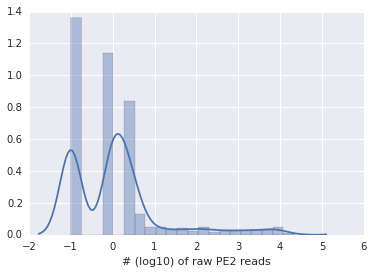

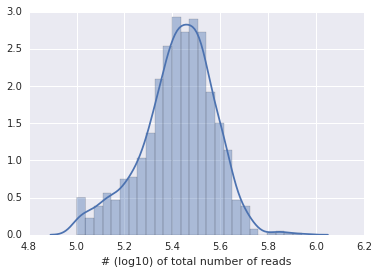

Plotting the relationship between the num of total reads and num of pe2 reads


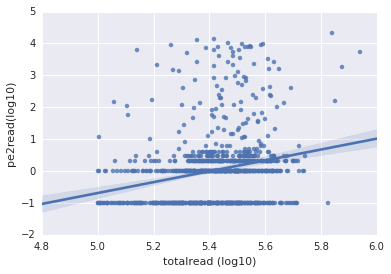


######Analysis on barcode-reads relationship

We sort the barcode in each cell by its # of PE2 reads

The distribution of the number (log10) of reads of the #1 barcode in each cell


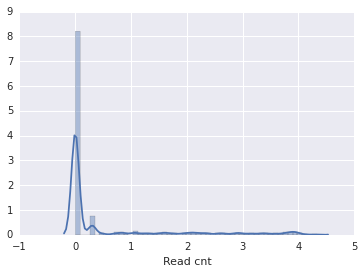

The distribution of the number (log10) of reads of the #2 barcode in each cell


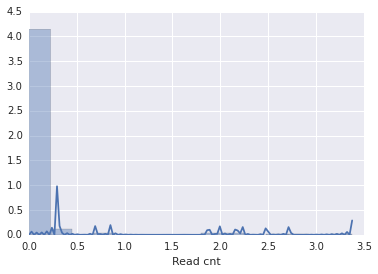

The distribution of the number (log10) of reads of the #3 barcode in each cell


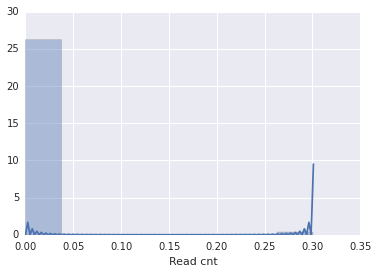

Now printing the information for all the cell who has >= one valid barcode:

[cellname,total # of pe2 reads, the list of barcodes, # of reads for each barcode, # of barcode]

['bc286', '323886', '1', 'TNGGNCCCNCGAANGGG', '1', '1']
['bc292', '322966', '2', 'ATGGCTGTTTATTCTAG,ACGAAACTTGGTCGAGG', '1,1', '2']
['bc725', '223421', '2', 'GGTAACATGGGTGGTGT', '1', '1']
['bc573', '257894', '2', 'GTGATGGAGAGNNNGGT', '1', '1']
['bc902', '159445', '2', 'TGGGCTTCTTGTAGTCT', '1', '1']
['bc317', '318446', '2', 'GGATGCGTTCTTGGCGT', '1', '1']
['bc786', '207179', '1', 'GTTGGGTTGAGGCGGGG', '1', '1']
['bc091', '407271', '2', 'GNAGGNTTCGNCGANNG', '1', '1']
['bc054', '427963', '3', 'GGTGGCCTAGCTGGGGC,AGGGATCGGATCGGTGN', '1,1', '2']
['bc268', '329691', '2', 'TGANNTNNAGCGCGGNG', '1', '1']
['bc258', '333126', '4', 'GGTGGCCTAGCTGGGGC,GCTTATCTGTGGATATC', '2,1', '2']
['bc019', '501386', '2', 'GGNGTATAGATCCCGCT', '1', '1']
['bc658', '239390', '2', 'AGGTCGGGGCCAGGGGG,GCTTATCTGTGGATATC', '1,1', '2']
['bc206', '346660

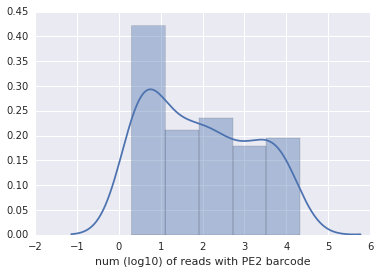

Num of valid cell with 1 unique barcode: 138
Num of valid cell with 2 unique barcode: 14
Num of valid cell with more than 2 unique barcode: 1
The distribtution of unique barcode in valid cell:


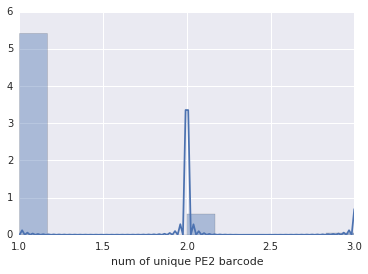


###### Analysing family statistics of ALL cell with barcode
(Recap)Num of valid cell : 153
Total num of barcode combo (family): 108
Num of invalid family with only one cell: 85
Num of valid family (with more than 1 cell): 23
Num of valid cells covered by valid family (with more than one cells): 68
Median num of valid cells in a valid family: 2.0


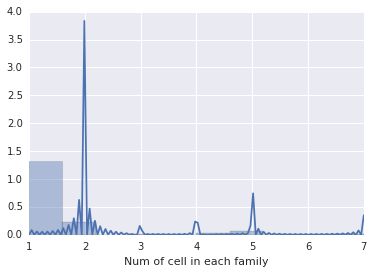

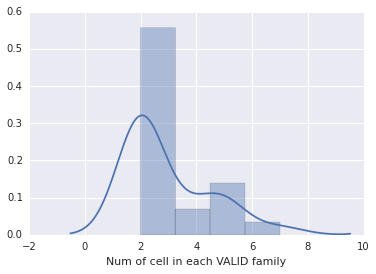


The barcode-combo of all the cells in the biggest family:
(size: 7 )
['AGGGATCGGATCGGNGT', 'GTGTAATTGTGTGGGTG', 'GTGTAATTGTGTGGGTG', 'GTGTAATTGTGTGGGTG', 'AGGGANCGGATCGNGCA', 'AGGGNTCGGATCGGNNN,GTGTAATTGTGTGGGTG', 'GTGTAATTGTGTGGGTG']
num of unique barcodes in this family (tolerance<=0bp): 2
The distribution of the number of cells each unique barcode in this family map to:


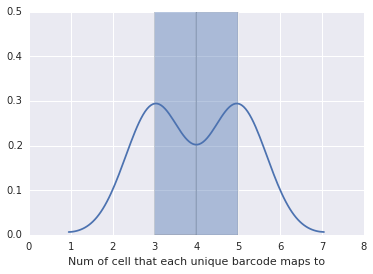

The most popular barcode in this family: ['GTGTAATTGTGTGGGTG']
The cells that have the most popular barcode in this family: ['GTGTAATTGTGTGGGTG', 'GTGTAATTGTGTGGGTG', 'GTGTAATTGTGTGGGTG', 'AGGGNTCGGATCGGNNN,GTGTAATTGTGTGGGTG', 'GTGTAATTGTGTGGGTG']
its size: 5


In [1099]:
mappingfile = '/cluster/zeng/research/lineage/mESC/post_split/cell-lineage_mapping_quality20_mismatch2_prefixsuffixtol2'
filtering_metric = '/cluster/zeng/research/lineage/mESC/stats/filtering_metrics.yaml'
analysis(mappingfile,filtering_metric)

#### Printing Indrop preprocessing stats ###
Rejected Reads: 37401945

Rejection Flags:

  BC1: 5303246

  BC2: 11264389

  No_W1: 12250319

  No_polyT: 2564185

  W1_in_R2: 6019806

Total Reads: 356413993

Valid Fraction: 0.8950603911895233

Valid Reads: 319012048

#### END ###


###### Analysis on the num of reads with PE2 barcode
Total num of cell: 992
Total num of raw PE2 barcode reads without filtering: 243980
Num of valid cell with more than 5 reads with raw PE2 barcode: 131


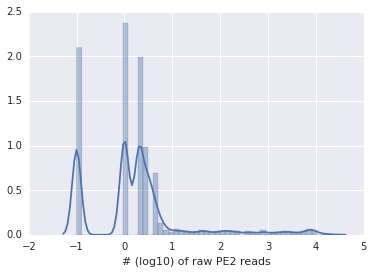

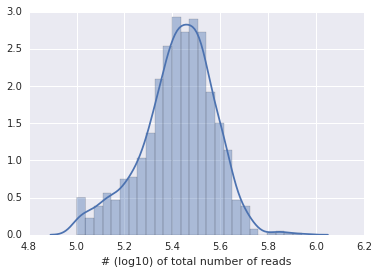

Plotting the relationship between the num of total reads and num of pe2 reads


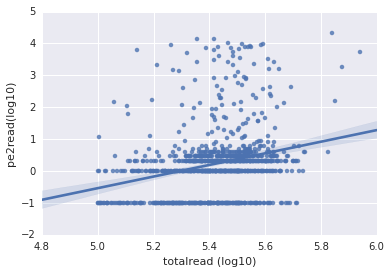


######Analysis on barcode-reads relationship

We sort the barcode in each cell by its # of PE2 reads

The distribution of the number (log10) of reads of the #1 barcode in each cell


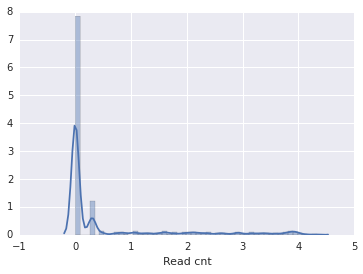

The distribution of the number (log10) of reads of the #2 barcode in each cell


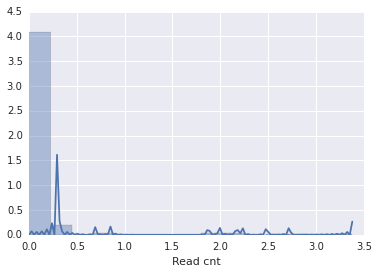

The distribution of the number (log10) of reads of the #3 barcode in each cell


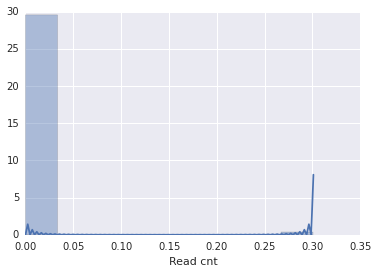

Now printing the information for all the cell who has >= one valid barcode:

[cellname,total # of pe2 reads, the list of barcodes, # of reads for each barcode, # of barcode]

['bc286', '323886', '2', 'TNGGNCCCNCGAANGGG', '1', '1']
['bc292', '322966', '2', 'ATGGCTGTTTATTCTAG,ACGAAACTTGGTCGAGG', '1,1', '2']
['bc725', '223421', '3', 'GGTAACATGGGTGGTGT', '1', '1']
['bc573', '257894', '2', 'GTGATGGAGAGNNNGGT', '1', '1']
['bc902', '159445', '2', 'TGGGCTTCTTGTAGTCT', '1', '1']
['bc317', '318446', '3', 'GGATGCGTTCTTGGCGT', '1', '1']
['bc786', '207179', '2', 'GTTGGGTTGAGGCGGGG', '1', '1']
['bc091', '407271', '2', 'GNAGGNTTCGNCGANNG', '1', '1']
['bc054', '427963', '4', 'GGTGGCCTAGCTGGGGC,AGGGATCGGATCGGTGN', '1,1', '2']
['bc268', '329691', '2', 'TGANNTNNAGCGCGGNG', '1', '1']
['bc258', '333126', '6', 'GGTGGCCTAGCTGGGGC,GCTTATCTGTGGATATC', '2,1', '2']
['bc019', '501386', '2', 'GGNGTATAGATCCCGCT', '1', '1']
['bc658', '239390', '2', 'AGGTCGGGGCCAGGGGG,GCTTATCTGTGGATATC', '1,1', '2']
['bc206', '346660

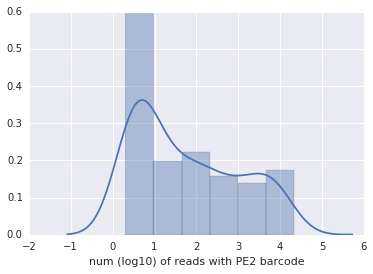

Num of valid cell with 1 unique barcode: 160
Num of valid cell with 2 unique barcode: 19
Num of valid cell with more than 2 unique barcode: 1
The distribtution of unique barcode in valid cell:


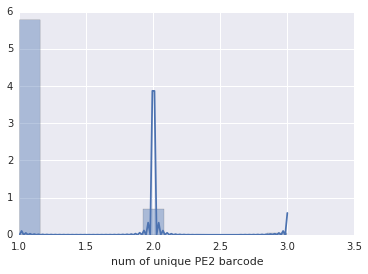


###### Analysing family statistics of ALL cell with barcode
(Recap)Num of valid cell : 180
Total num of barcode combo (family): 127
Num of invalid family with only one cell: 103
Num of valid family (with more than 1 cell): 24
Num of valid cells covered by valid family (with more than one cells): 77
Median num of valid cells in a valid family: 2.0


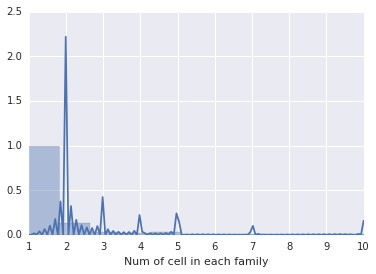

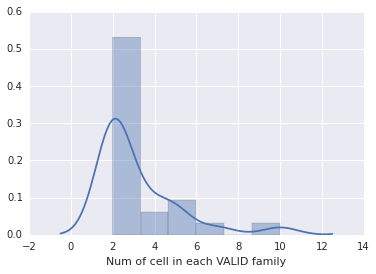


The barcode-combo of all the cells in the biggest family:
(size: 10 )
['TAGGACCCACGAAAGGG', 'TAGGNCCCNCGAAAGGN', 'TAGGACCCACGAAAGGG', 'TAGGACCCACGAAAGGG', 'TAGGACCCACGAAAGGG', 'TAGGACCCACGAAAGGG', 'TAGGACCCACGAAAGGG', 'CTTGATTTGAGGGTGGG,TAGGACCCACGAAAGGG', 'CTTGATTTGAGGGTGGG', 'NAGGCCCCACGAAAGGG']
num of unique barcodes in this family (tolerance<=0bp): 2
The distribution of the number of cells each unique barcode in this family map to:


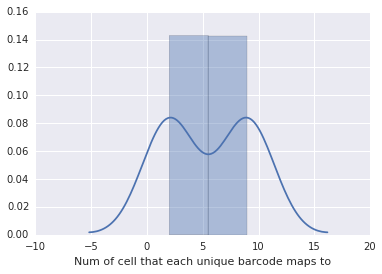

The most popular barcode in this family: ['TAGGNCCCNCGAAAGGN', 'TAGGACCCACGAAAGGG', 'NAGGCCCCACGAAAGGG']
The cells that have the most popular barcode in this family: ['TAGGACCCACGAAAGGG', 'TAGGNCCCNCGAAAGGN', 'TAGGACCCACGAAAGGG', 'TAGGACCCACGAAAGGG', 'TAGGACCCACGAAAGGG', 'TAGGACCCACGAAAGGG', 'TAGGACCCACGAAAGGG', 'CTTGATTTGAGGGTGGG,TAGGACCCACGAAAGGG', 'NAGGCCCCACGAAAGGG']
its size: 9


In [1100]:
mappingfile = '/cluster/zeng/research/lineage/mESC/post_split/cell-lineage_mapping_quality20_mismatch2_prefixsuffixtol4'
filtering_metric = '/cluster/zeng/research/lineage/mESC/stats/filtering_metrics.yaml'
analysis(mappingfile,filtering_metric)